# Implicit Neural Representations for Diffuser Calibration

Neerja Aggarwal & Eric Markley & ChatGPT4o

Oct 8th, 2024

Prompting: I want code for fitting a coordinate MLP to an image of a diffuser. Write the basic code skeleton with lots of comments.  Include: 1. importing the image, 2. deciding the mlp structure, 3. gpu set up, 4. training, and output

In [29]:
# Import necessary libraries
import torch  # PyTorch library for GPU and tensor operations
import torch.nn as nn  # For creating neural network layers
import torch.optim as optim  # Optimizer for training the neural network
import torchvision.transforms as transforms  # For image transformations
from PIL import Image  # To handle image loading
import matplotlib.pyplot as plt  # For visualizing images and results
import numpy as np  # For basic array manipulations
import math  # For mathematical functions in positional encoding


In [32]:
# Step 1: Load and preprocess the image
def load_image(image_path):
    """
    Load an image using PIL and convert it to a tensor.
    Args:
        image_path (str): Path to the image file
    Returns:
        torch.Tensor: Normalized image tensor
    """
    # Open the image using PIL
    image = Image.open(image_path)
    
    # Define transformations: resize, convert to tensor, and normalize
    transform = transforms.Compose([
        transforms.Resize((256, 256)),  # Resize image to a fixed size
        transforms.ToTensor(),  # Convert image to tensor with shape [C, H, W]
        transforms.Normalize([0.5], [0.5])  # Normalize to range [-1, 1]
    ])
    
    # Apply transformations to the image and convert to tensor
    image_tensor = transform(image).permute(1, 2, 0)  # Convert to [H, W, C] for coordinate mapping
    return image_tensor


# Step 2: Define a positional encoding function for the coordinates
def positional_encoding(coords, num_frequencies=10):
    """
    Apply positional encoding to a given set of coordinates.
    Args:
        coords (torch.Tensor): Input tensor of shape [N, 2] representing 2D coordinates.
        num_frequencies (int): Number of frequency bands to use for encoding.
    Returns:
        torch.Tensor: Positional encoded features of shape [N, 2*num_frequencies*2 + 2].
    """
    encoded = [coords]  # Start with the original coordinates
    for i in range(num_frequencies):
        for func in [torch.sin, torch.cos]:
            # Apply sine and cosine encoding with varying frequencies
            encoded.append(func((2.0 ** i) * math.pi * coords))

    # Concatenate all encodings along the feature dimension
    return torch.cat(encoded, dim=-1)

# Step 3: Create an MLP with adjusted input dimensions for positional encoding
class EnhancedCoordinateMLP(nn.Module):
    """
    A Multi-Layer Perceptron (MLP) that maps 2D coordinates with positional encoding to grayscale values.
    Args:
        input_dim (int): Number of input features (after positional encoding).
        hidden_dim (int): Number of neurons in each hidden layer.
        output_dim (int): Number of output features (1 for grayscale).
        num_layers (int): Number of layers in the MLP.
    """
    def __init__(self, input_dim=42, hidden_dim=128, output_dim=1, num_layers=3):
        super(EnhancedCoordinateMLP, self).__init__()
        layers = []

        # Input layer
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())

        # Hidden layers
        for _ in range(num_layers - 2):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())

        # Output layer (1-dimensional output for grayscale values)
        layers.append(nn.Linear(hidden_dim, output_dim))
        layers.append(nn.Sigmoid())  # Use Sigmoid to constrain output between 0 and 1

        # Register the network as a sequential model
        self.network = nn.Sequential(*layers)

    def forward(self, coords):
        """
        Forward pass through the MLP.
        Args:
            coords (torch.Tensor): 2D coordinates with positional encoding of shape [N, input_dim].
        Returns:
            torch.Tensor: Predicted grayscale values of shape [N, 1].
        """
        return self.network(coords)


# Step 5: Prepare the training dataset - map 2D coordinates to pixel values
def create_coordinate_dataset(image_tensor, device, num_frequencies=10):
    """
    Create a dataset of coordinates and corresponding pixel values from the image tensor.
    Args:
        image_tensor (torch.Tensor): Image tensor of shape [H, W, 1].
        device (torch.device): Device to store tensors.
        num_frequencies (int): Number of frequencies for positional encoding.
    Returns:
        coords, pixel_values: Positional encoded coordinate-pixel value pairs for training the MLP.
    """
    H, W, C = image_tensor.shape  # Get the height, width, and channels (1 for grayscale)

    # Create a grid of normalized coordinates
    y_coords = torch.linspace(0, 1, H)
    x_coords = torch.linspace(0, 1, W)
    grid = torch.stack(torch.meshgrid(x_coords, y_coords), dim=-1)  # Shape: [H, W, 2]

    # Flatten the grid and image tensor for input-output pairs
    coords = grid.view(-1, 2)  # Shape: [H*W, 2]
    pixel_values = image_tensor.view(-1, C)  # Shape: [H*W, 1]

    # Apply positional encoding to the 2D coordinates
    encoded_coords = positional_encoding(coords, num_frequencies)

    return encoded_coords.to(device), pixel_values.to(device)

# Step 6: Training loop
def train(model, optimizer, loss_function, coords, pixel_values, num_epochs=500):
    """
    Train the MLP model to fit the image.
    Args:
        model (nn.Module): MLP model
        coords (torch.Tensor): 2D coordinates of each pixel
        pixel_values (torch.Tensor): Target RGB values of each pixel
        num_epochs (int): Number of epochs to train
    """
    for epoch in range(num_epochs):
        # Set model to training mode
        model.train()
        
        # Forward pass: Predict RGB values from coordinates
        outputs = model(coords)
        
        # Compute the loss
        loss = loss_function(outputs, pixel_values)
        
        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print loss every 50 epochs
        if epoch % 50 == 0:
            print(f"Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}")

# Step 7: Output the result
def visualize_output(model, coords, image_shape):
    """
    Visualize the MLP's output as an image.
    Args:
        model (nn.Module): Trained MLP model
        coords (torch.Tensor): 2D coordinates of each pixel
        image_shape (tuple): Shape of the original image (H, W, C)
    """
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        # Get the RGB values predicted by the model
        output_image = model(coords).view(*image_shape).cpu().numpy()
    
    # Plot the reconstructed image
    plt.imshow(output_image)
    plt.axis('off')
    plt.title("Reconstructed Image from MLP")
    plt.show()


Using device: cpu


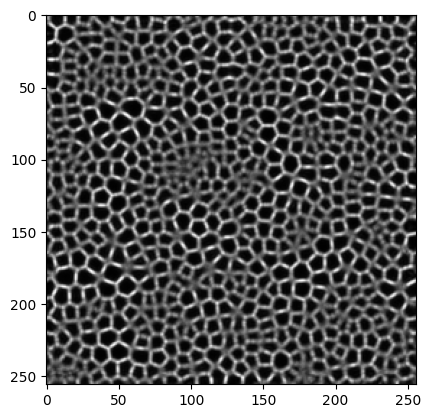

In [35]:
# Step 3: Set up GPU/CPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Step 5: Set up the MLP model, optimizer, and loss function
image_tensor = load_image("../Calibration_Data/psf_090_1.png").to(device)
plt.imshow(image_tensor, cmap='gray')


In [37]:

model = EnhancedCoordinateMLP().to(device)  # Initialize model and send to GPU/CPU
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer
loss_function = nn.MSELoss()  # Mean Squared Error loss for image fitting

# Create the coordinate-pixel dataset 
coords, pixel_values = create_coordinate_dataset(image_tensor,device)


Epoch [0/500], Loss: 1.1127
Epoch [50/500], Loss: 0.3864
Epoch [100/500], Loss: 0.3852
Epoch [150/500], Loss: 0.3850
Epoch [200/500], Loss: 0.3849
Epoch [250/500], Loss: 0.3848
Epoch [300/500], Loss: 0.3848
Epoch [350/500], Loss: 0.3847
Epoch [400/500], Loss: 0.3847
Epoch [450/500], Loss: 0.3847


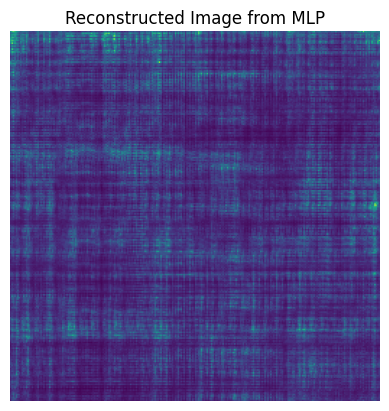

In [38]:
# and train the MLP
train(model,  optimizer, loss_function, coords, pixel_values)

# Visualize the output
visualize_output(model, coords, image_tensor.shape)

In [ ]:
plt.imshow(image_tensor, cmap='gray')